In [1]:
## Import Essential Libraries
import numpy as np
import pandas as pd
import os
import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor
import matplotlib.pyplot as plt
import string
import scipy.io as sio
import scipy.linalg as slinalg
import torchvision
from torchvision import datasets, transforms
import glob
from scipy.io import savemat
from torch.autograd import Variable

import math
import json
import tifffile
import random

from IPython.display import clear_output

In [2]:
class PointCloudTransformer(nn.Module):
    def __init__(self, input_dim=3, num_heads=4, dim_feedforward=1024, num_encoder_layers=3):
        super(PointCloudTransformer, self).__init__()
        
        # Embedding layer to project input points to the model dimension
        self.embedding_dim = 1024
        self.fc1_dim = np.uint16(self.embedding_dim / 2)
        self.fc2_dim = np.uint16(self.fc1_dim / 2)
        self.fc3_dim = np.uint16(self.fc2_dim / 2)
        # self.fc2_dim = 64
        self.point_embedding = nn.Linear(input_dim, self.embedding_dim)

        self.output_pose_dim = 3
        self.output_cov_dim = 6
        
        # Positional encoding (not strictly necessary for point clouds but can help)
        self.pos_encoder = PositionalEncoding(self.embedding_dim, dropout=0.1, max_len=2000)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embedding_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        # Output layers for pose prediction
        self.fc1_pose = nn.Linear(self.embedding_dim, self.fc1_dim)
        self.fc2_pose = nn.Linear(self.fc1_dim, self.fc2_dim)
        self.fc3_pose = nn.Linear(self.fc2_dim, self.fc3_dim)
        self.fc_out_pose = nn.Linear(self.fc3_dim, self.output_pose_dim)  # output_dim = 3 (x, y, azimuth)

        self.fc1_cov = nn.Linear(self.embedding_dim, self.fc1_dim)
        self.fc2_cov = nn.Linear(self.fc1_dim, self.fc2_dim)
        self.fc3_cov = nn.Linear(self.fc2_dim, self.fc3_dim)
        self.fc_out_cov = nn.Linear(self.fc3_dim, self.output_cov_dim)  # output_dim = 3 (x, y, azimuth)
        
    def forward(self, x):
        # x shape: [batch_size, N, 3] where N is the number of points
        
        # Embed each point
        x = self.point_embedding(x)  # [batch_size, N, embedding_dim]
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Pass through transformer encoder
        x = self.transformer_encoder(x)  # [batch_size, N, embedding_dim]
        
        # Global pooling (mean across points)
        x = torch.mean(x, dim=1)  # [batch_size, embedding_dim]
        
        # MLP for final pose prediction
        x_pose = F.relu(self.fc1_pose(x))
        x_pose = F.relu(self.fc2_pose(x_pose))
        x_pose = F.relu(self.fc3_pose(x_pose))
        pose = self.fc_out_pose(x_pose)  # [batch_size, 3] where 3 = (x, y, azimuth)

        # MLP for final cov prediction
        x_cov = F.relu(self.fc1_cov(x))
        x_cov = F.relu(self.fc2_cov(x_cov))
        x_cov = F.relu(self.fc3_cov(x_cov))
        cov = self.fc_out_cov(x_cov)  # [batch_size, 3] where 3 = (x, y, azimuth)
        
        return pose, cov

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x is [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [3]:
def pose_norm_loss(pose_pred, pose_target, cov_est, num_batch ):
    I = torch.eye(3)
    loss = 0

    for i in range(num_batch):
        pose_error = pose_target[:, i] - pose_pred[:, i]
        loss_j = torch.matmul(torch.matmul(pose_error, torch.linalg.inv(cov_est)), pose_error) / 10000 / num_batch

        # Add loss for each covariance estimation
        loss += loss_j

    # Return the loss
    return loss

def cov_cholesky_norm_loss(cov_mat_target, cov_mat_pred_L, num_batch ):
    I = torch.eye(3)
    loss = 0

    for i in range(num_batch):
        # Calculate the loss
        cov_target = cov_mat_target[i, :, :]
        L_target = torch.linalg.cholesky(cov_target)
        L_pred = cov_mat_pred_L[i, :, :]

        cov_pred = torch.matmul(L_pred, L_pred.T)
        cov_ratio = torch.matmul(torch.matmul(torch.linalg.inv(L_target.T), cov_pred), torch.linalg.inv(L_target))

        cov_pred_error = torch.matmul((I - cov_ratio), (I - cov_ratio).T)
        loss_j = 1/2 * torch.sqrt(torch.trace(cov_pred_error)) / 10000

        # Add loss for each covariance estimation
        loss += loss_j

    # Return the loss
    return loss



In [ ]:
# Enable gpu processing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume we have a dataset of point clouds and poses
batch_size = 1
num_points = 1024  # N value in your 3xN matrix

# Initialize model
model = PointCloudTransformer(input_dim=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
loss_fn = nn.MSELoss()

# Define the loss function and optimizer
criterion       = nn.MSELoss()
criterion_pose  = nn.L1Loss()
criterion_cov   = nn.L1Loss()

print(device)

cuda:0


In [5]:
train_cov = False
if (train_cov == True):
    model.load_state_dict(torch.load('./model/spherical/lidarCNN_Sph_Pose10000.pth'))

    # Freeze the convolutional layers
    model.point_embedding.weight.requires_grad = False
    model.point_embedding.bias.requires_grad = False
    # model.pos_encoder.weight.requires_grad = False
    # model.pos_encoder.bias.requires_grad = False
    # model.transformer_encoder.weight.requires_grad = False
    # model.transformer_encoder.bias.requires_grad = False

    # Freeze the layers used to calculate the pose
    model.fc1_pose.weight.requires_grad = False
    model.fc1_pose.bias.requires_grad = False
    model.fc2_pose.weight.requires_grad = False
    model.fc2_pose.bias.requires_grad = False
    model.fc3_pose.weight.requires_grad = False
    model.fc3_pose.bias.requires_grad = False
    model.fc_out_pose.weight.requires_grad = False
    model.fc_out_pose.bias.requires_grad   = False

    # Unfreeze the layers used to calculate the covariance
    model.fc1_cov.weight.requires_grad = True
    model.fc1_cov.bias.requires_grad   = True
    model.fc2_cov.weight.requires_grad = True
    model.fc2_cov.bias.requires_grad   = True
    model.fc3_cov.weight.requires_grad = True
    model.fc3_cov.bias.requires_grad   = True
    model.fc_out_cov.weight.requires_grad = True
    model.fc_out_cov.bias.requires_grad   = True

else:
    # model.load_state_dict(torch.load('./model/model_AzEl_Mini_Pose_Trained_10000.pth'))
    # Freeze the layers used to calculate the covariance
    model.fc1_cov.weight.requires_grad = False
    model.fc1_cov.bias.requires_grad   = False
    model.fc2_cov.weight.requires_grad = False
    model.fc2_cov.bias.requires_grad   = False
    model.fc3_cov.weight.requires_grad = False
    model.fc3_cov.bias.requires_grad   = False
    model.fc_out_cov.weight.requires_grad = False
    model.fc_out_cov.bias.requires_grad   = False

In [6]:
num_train = 30
posVehInNavLog = []
azVehInNavLog = []
lidarPointCloudLog = []
lidarIntensityLog = []

numTransformPoints = num_points

lidarDataPath = "/home/julian/sandbox/vt/lidar-ml-pose/lidarCNN/spherical/point_clouds/"
lidarDataFiles = sorted(os.listdir(lidarDataPath))

# Create figure and axis
fig = plt.figure(figsize=(10, 10))

# Lidar Point Cloud Regularization Factor
lidarRegFactor = 1000
RAD_TO_DEG = 180 / np.pi

for i in range(num_train):
    lidarTrajPath = lidarDataPath + lidarDataFiles[i] + '/'
    lidarJsonFiles = sorted(os.listdir(lidarTrajPath))

    for j in range(len(lidarJsonFiles)):
        lidarJson = lidarTrajPath + lidarJsonFiles[j]
        with open(lidarJson, 'r') as file:
            lidar_data = json.load(file)

        trajectoryStr = lidar_data['entries'][0]['trajectoryStr']
        trajectoryStr = trajectoryStr[:-4]
        posVehInNavTruth = lidar_data['entries'][0]['posVehInNavTruth']
        azVehInNavTruth = lidar_data['entries'][0]['azVehInNavTruth']
        pointCloud = np.array(lidar_data['entries'][0]['pointCloud'])
        pointIntensity = np.array(lidar_data['entries'][0]['pointIntensity'])

        if (pointCloud.shape[1] > numTransformPoints):
            sortArg = np.argsort(pointIntensity)[::-1]
            sortArg = np.argsort(np.linalg.vector_norm(pointCloud,  axis=0) )

            sampleRatio = np.uint(np.ceil(pointCloud.shape[1] / numTransformPoints))

            pointCloudTrunc = pointCloud[:,sortArg][:,:numTransformPoints]
            pointIntensityTrunc = pointIntensity[sortArg][:numTransformPoints]

            pointCloudTrunc = pointCloud[:,::sampleRatio]
            pointIntensityTrunc = pointIntensity[::sampleRatio]

        # pad the lidar point with zeros in the dimension is less than X
        if (pointCloudTrunc.shape[1] < numTransformPoints):
            pointCloudTrunc = np.pad(pointCloudTrunc, ((0,0), (0,numTransformPoints - pointCloudTrunc.shape[1])), mode='constant', constant_values=0)
            pointIntensityTrunc = np.pad(pointIntensityTrunc, ((0), (numTransformPoints - pointIntensityTrunc.shape[0])), mode='constant', constant_values=0)
        # otherwise truncate the point cloud by order of the most intense returns

        posVehInNavLog.append(posVehInNavTruth)
        azVehInNavLog.append(azVehInNavTruth)
        lidarPointCloudLog.append(pointCloudTrunc.T)
        lidarIntensityLog.append(pointIntensityTrunc)

        # # Clear previous output
        # clear_output(wait=True)
        
        # fig.clf()
        # ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        # # Show the project lidar points
        # ax1.scatter(pointCloudTrunc[0,:], pointCloudTrunc[1,:], pointCloudTrunc[2,:], marker='o')
        # ax1.set_xlabel('X Label')
        # ax1.set_ylabel('Y Label')
        # ax1.set_zlabel('Z Label')
        # ax1.set_xlim([-5000, 5000])  # Adjust these values as needed
        # ax1.set_ylim([-5000, 5000])
        # ax1.set_zlim([-1000, 1000])

        # ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        # # Show the project lidar points
        # ax2.scatter(pointCloud[0,:], pointCloud[1,:], pointCloud[2,:], marker='o')
        # ax2.set_xlabel('X Label')
        # ax2.set_ylabel('Y Label')
        # ax2.set_zlabel('Z Label')
        # ax2.set_xlim([-5000, 5000])  # Adjust these values as needed
        # ax2.set_ylim([-5000, 5000])
        # ax2.set_zlim([-1000, 1000])

        # # This ensures the plot is displayed during the loop
        # plt.draw()
        # display(plt.gcf())

    # print(i)


# Tensorify our arrays
posVehInNavLog = torch.Tensor(np.array(posVehInNavLog) / lidarRegFactor)
azVehInNavLog  = torch.Tensor(np.array(azVehInNavLog))
lidarPointCloudLog = torch.Tensor(np.array(lidarPointCloudLog))
lidarIntensityLog = torch.Tensor(np.array(lidarIntensityLog))

x = lidarPointCloudLog
y = lidarIntensityLog.unsqueeze(-1)

print(x.shape)
print(y.shape)

lidarPointIntCloudLog = torch.cat((x, y), axis=2)


torch.Size([6120, 1024, 3])
torch.Size([6120, 1024, 1])


<Figure size 1000x1000 with 0 Axes>

In [7]:
input_tensor = lidarPointIntCloudLog[[0,1,2,4,5], :, :]
input_tensor.shape
# pose_pred = model(input_tensor)
pose_pred, cov_pred = model(input_tensor.to(device))
pose_pred, cov_pred

(tensor([[-0.0064, -0.1117, -0.0794],
         [-0.0004, -0.1156, -0.0826],
         [-0.0039, -0.1013, -0.0868],
         [ 0.0062, -0.1114, -0.0804],
         [ 0.0051, -0.1172, -0.0852]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[-0.0379, -0.0083, -0.0381, -0.1288,  0.1550,  0.1133],
         [-0.0345, -0.0138, -0.0301, -0.1321,  0.1546,  0.1049],
         [-0.0303, -0.0088, -0.0378, -0.1360,  0.1529,  0.1078],
         [-0.0329, -0.0061, -0.0300, -0.1298,  0.1583,  0.1020],
         [-0.0334, -0.0157, -0.0286, -0.1279,  0.1542,  0.1062]],
        device='cuda:0', grad_fn=<AddmmBackward0>))

In [8]:
import random

# Step 2: Arrange into batches
def create_batches(numbers, batch_size):
    """Split a list into batches of specified size"""
    return [numbers[i:i + batch_size] for i in range(0, len(numbers), batch_size)]


In [9]:
# Azimuth Angle Regularization Factor
azRegFactor = 1

cov_est = torch.tensor([(10 / lidarRegFactor) ** 2, (10 / lidarRegFactor) ** 2, (1 / RAD_TO_DEG / azRegFactor) ** 2])
cov_est = torch.diag(cov_est)

numPcImg = lidarIntensityLog.shape[0]
batch_size = 16

training_enable = True
train_cov = False

## Training Section
if (training_enable == True):
    num_epoch = 1000+1

    for epoch in range(0,num_epoch+1):
        running_loss = 0

        unique_numbers = random.sample(range(numPcImg), numPcImg)  # Gets 10 unique numbers from 0-100

        batched_arrays = create_batches(unique_numbers, batch_size)

        for batch in batched_arrays:
            # Pull the input tensor
            input_tensor = lidarPointIntCloudLog[batch, :, :]
            # input_tensor = input_tensor.unsqueeze(1)

            # Pull the target tensors
            pose_target = torch.zeros([3,batch.__len__()])
            pose_target[0,:] = posVehInNavLog[batch,0]
            pose_target[1,:] = posVehInNavLog[batch,1]
            pose_target[2,:] = azVehInNavLog[batch]

            # Run the lidar image through the lidar CNN
            pose_pred, cov_pred = model(input_tensor.to(device))
            pose_pred = Tensor.cpu(pose_pred)
            cov_pred  = Tensor.cpu(cov_pred)

            pos_pred = pose_pred[:,0:2]
            att_pred = pose_pred[:, 2]

            # Concatenate the target
            # target = torch.cat((pos_target, att_target, cov_target), axis=1)

            # Compute the estimation loss
            # loss_pose = criterion_pose(pose_pred,pose_target)

            if (train_cov == True):
                
                cov_mat_target = covPoseInNavLog[:,img_idx,:,:]

                # Convert the covariance prediction into a matrix
                cov_mat_pred_L = torch.zeros(num_train, 3, 3)
                cov_mat_pred_D = torch.zeros(num_train, 3, 3)
                cov_mat_pred_L[:, 0, 0] = cov_pred[:, 0]
                cov_mat_pred_L[:, 1, 0] = cov_pred[:, 1]
                cov_mat_pred_L[:, 1, 1] = cov_pred[:, 2]
                cov_mat_pred_L[:, 2, 0] = cov_pred[:, 3]
                cov_mat_pred_L[:, 2, 1] = cov_pred[:, 4]
                cov_mat_pred_L[:, 2, 2] = cov_pred[:, 5]

                cov_mat_pred_D[:, 0, 0] = 1
                cov_mat_pred_D[:, 1, 1] = 1
                cov_mat_pred_D[:, 2, 2] = 1

                cov_mat_pred = torch.zeros(num_train, 3, 3)
                for i in range(num_train):
                    cov_mat_pred[i,:,:] = torch.matmul( torch.matmul(cov_mat_pred_L[i,:,:], cov_mat_pred_D[i,:,:]), cov_mat_pred_L[i,:,:].T.squeeze())

                loss = cov_cholesky_norm_loss(cov_mat_target, cov_mat_pred_L, batch_size)
            else:
                loss = pose_norm_loss(pose_pred.T, pose_target, cov_est, batch.__len__())
                # loss = criterion_pose(pose_pred.T, pose_target)

            loss.backward()

            # Optimize
            optimizer.step()
            optimizer.zero_grad()

            # Debugging
            running_loss += loss.item()
        # End of Iteration Loop

        # Break training if loss fall belows some threshold
        # if (epoch % 1000 == 0):
        #     scheduler.step()

        # Print Results
        if epoch % 1 == 0:
            print("Epoch: %d, loss: %1.10f" % (epoch, running_loss))
        if epoch % 100 == 0:
            print('Saving model!')
            if (train_cov == False):
                file_name = 'lidarTrans_Pose' + str(epoch)
                torch.save(model.state_dict(), './models/transformer_pose/'+file_name+'.pth')
            else:
                file_name = 'lidarTrans_PoseCov' + str(epoch)
                torch.save(model.state_dict(), './models/transformer_pose/'+file_name+'.pth')

            # End of Save Model

    # Final Training Results
    print("Final Training Results: loss: %1.10f" % (running_loss/numPcImg))

# End of Epoch Loop
else: # Training Enable False
    # Load the state dictionary
    model.load_state_dict(torch.load('./model/model_AzEl_Mini_Pose_Trained_10000.pth'))
    # model.load_state_dict(torch.load('./model/model_Pose_Trained.pth'))
# End of Training

/home/julian/miniconda3/envs/lidar-ml-py/lib/python3.9/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0, loss: 81.4530457254
Saving model!
Epoch: 1, loss: 1.3522582684
Epoch: 2, loss: 1.0324497068
Epoch: 3, loss: 38.2153299261
Epoch: 4, loss: nan
Epoch: 5, loss: nan
Epoch: 6, loss: nan
Epoch: 7, loss: nan
Epoch: 8, loss: nan
Epoch: 9, loss: nan
Epoch: 10, loss: nan
Epoch: 11, loss: nan
Epoch: 12, loss: nan
Epoch: 13, loss: nan
Epoch: 14, loss: nan
Epoch: 15, loss: nan
Epoch: 16, loss: nan
Epoch: 17, loss: nan
Epoch: 18, loss: nan
Epoch: 19, loss: nan
Epoch: 20, loss: nan
Epoch: 21, loss: nan
Epoch: 22, loss: nan
Epoch: 23, loss: nan
Epoch: 24, loss: nan
Epoch: 25, loss: nan
Epoch: 26, loss: nan
Epoch: 27, loss: nan
Epoch: 28, loss: nan
Epoch: 29, loss: nan
Epoch: 30, loss: nan
Epoch: 31, loss: nan
Epoch: 32, loss: nan
Epoch: 33, loss: nan
Epoch: 34, loss: nan
Epoch: 35, loss: nan
Epoch: 36, loss: nan
Epoch: 37, loss: nan
Epoch: 38, loss: nan
Epoch: 39, loss: nan
Epoch: 40, loss: nan
Epoch: 41, loss: nan
Epoch: 42, loss: nan
Epoch: 43, loss: nan
Epoch: 44, loss: nan
Epoch: 45, lo

KeyboardInterrupt: 

In [ ]:
numPcImg

6120

In [ ]:
model.load_state_dict(torch.load('./models/transformer_pose/lidarTrans_Pose1000.pth'))

num_train = 95

sampleArray = []
poseArray = []

lidarDataPath = "/home/julian/sandbox/vt/lidar-ml-pose/lidarCNN/spherical/point_clouds/"
lidarDataFiles = sorted(os.listdir(lidarDataPath))

# Lidar Point Cloud Regularization Factor
lidarRegFactor = 1000
RAD_TO_DEG = 180 / np.pi

for i in range(num_train):
    lidarTrajPath = lidarDataPath + lidarDataFiles[i] + '/'
    lidarJsonFiles = sorted(os.listdir(lidarTrajPath))

    for j in range(len(lidarJsonFiles)):
        lidarJson = lidarTrajPath + lidarJsonFiles[j]
        with open(lidarJson, 'r') as file:
            lidar_data = json.load(file)

        trajectoryStr = lidar_data['entries'][0]['trajectoryStr']
        trajectoryStr = trajectoryStr[:-4]
        posVehInNavTruth = lidar_data['entries'][0]['posVehInNavTruth']
        azVehInNavTruth = lidar_data['entries'][0]['azVehInNavTruth']
        pointCloud = np.array(lidar_data['entries'][0]['pointCloud'])
        pointIntensity = np.array(lidar_data['entries'][0]['pointIntensity'])
        sampleNum = lidar_data['entries'][0]['sampleNum']

        # fetch the N most intensity returns
        numLidarPoints = pointCloud.shape[1]

        # pad the lidar point with zeros in the dimension is less than X
        if (numLidarPoints < numTransformPoints):
            pointCloud = np.pad(pointCloud, ((0,0), (0,numTransformPoints - numLidarPoints)), mode='constant', constant_values=0)
            pointIntensity = np.pad(pointIntensity, ((0), (numTransformPoints - numLidarPoints)), mode='constant', constant_values=0)
        # otherwise truncate the point cloud by order of the most intense returns
        else:
            sortArg = np.argsort(pointIntensity)[::-1]
            pointIntensity = pointIntensity[sortArg][:numTransformPoints]
            pointCloud = pointCloud[:,sortArg][:,:numTransformPoints]

        input_tensor = torch.Tensor(pointCloud.T).unsqueeze(0)

        # Run the lidar image through the lidar CNN
        pose_pred = model(input_tensor.to(device))
        pose_pred = Tensor.cpu(pose_pred)

        # log results
        sampleArray.append(sampleNum)
        poseArray.append(pose_pred.squeeze().detach().numpy())


sampleArray = np.array(sampleArray)
poseArray = np.array(poseArray)

In [ ]:
sampleArray.shape

(19380,)

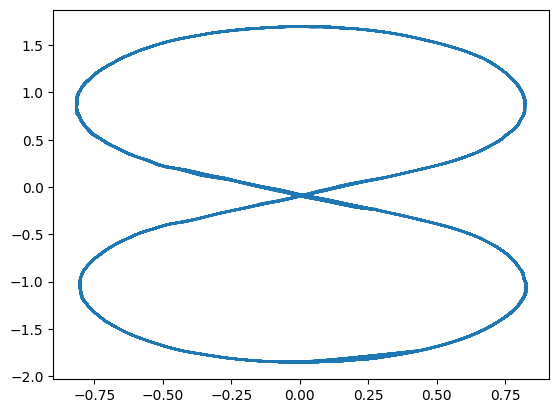

In [ ]:
plt.figure
plt.plot(poseArray[:,0], poseArray[:,1])

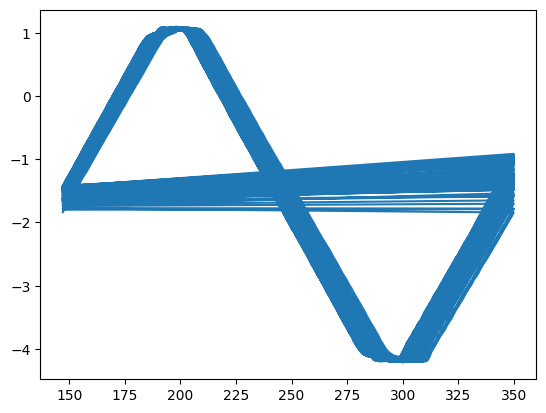

In [ ]:
plt.figure
plt.plot(sampleArray, poseArray[:,2])